## Capstone Project - The Battle of the Neighborhood

In [1]:
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Introduction:

I am a aspirirng data scientist, recently moved to San Jose, California. Looking for afordable good city to rent near Santa Clara County, California. The apartment in Santa Clara County must meet the following demands:
apartment must be 2 or 3 bedrooms
- City should be safe with low number of voilent crime
- price of rent not exceed $7,000 per month
- top ammenities in the selected neighborhood shall be similar to current residence
- desirable to have venues such as coffee shops,restaurants, gym and food shops

#### Business Problem 

The challenge is to find a suitable apartment for rent in San Jose California that complies with the demands on location, price and venues. The data required to resolve this challenge is described in the following section 2, below.

#### Interested Audience

I believe this is a relevant challenge with valid questions for anyone moving to other large city. The methodology  is also applicable for anyone interested in exploring starting or locating a new business in any city. Lastly, it can also serve as a good practical exercise to develop Data Science skills.

### 2. Data Section

The following data is required to answer the issues of the problem:

- List of Boroughs and neighborhoods of San Jose with their geodata (latitude and longitude)
- List of rail and cal stations in San Jose with their address location
- List of apartments for rent in San Jose area with their addresses and price
- Preferably, a list of apartment for rent with additional information, such as price, address, area, # of beds, etc
- Venues for each San Jose neighborhood ( than can be clustered)
- Venues for rail stations, as needed
- list of crime data of each city 

### Data Collection

The data of this project is gather from different sources and combined together for final exploraton and analysis: 

- Web Scrapping of apartment rent data from Craiglist.
- Crime data of Santa Clara county  
- FourSquare API for gathering venues

Craiglist web scrapping provides neighboorhood name, number of bedroom, rent price and square feet of apartment.These data is used for exploratory data analysis. 
Fouresquare API will be used to source venues of ineterst. 


## Data Preparation(Web Scrapping data from Cariglist)

In [3]:
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
import numpy as np


In [3]:
from requests import get

#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/sby/apa?hasPic=1) #get rid of those lame-o')#s that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) 
print(len(posts)) 

<class 'bs4.element.ResultSet'>
120


In [187]:
#grab the first post
post_one = posts[0]
post_one
index = 0
for post in posts:
    index += 1 

In [188]:
post_one_price = post_one.a.text
post_one_price


'\n$2195\n'

In [6]:
#grab the time of the post in datetime format
post_one_time = post_one.find('time', class_ = 'result-date')
post_one_datetime = post_one_time['datetime']


In [7]:
#getting tile of post one
post1_title = post_one.find('a', class_ = 'result-title hdrlnk')
post1_link = post1_title['href']
post1_link

'https://sfbay.craigslist.org/sby/apa/d/san-jose-welcome-home-your-1-bedroom/7051723028.html'

In [8]:
post1_text = post1_title.text
post1_title.text

'Welcome home! Your 1 bedroom apt in Willow Glen, Totally RENOVATED!'

In [9]:
#getting post 1 neighboorhood
post1_neigh = post_one.find('span', class_ = 'result-hood').text
post1_neigh

' (willow glen / cambrian)'

In [10]:
post1_bed= post_one.find('span', class_ = 'housing').text
post1_bed1 = post1_bed.split()[0]
post1_bed1

post1_sqrt = post1_bed.split()[2][:-3]#cleans fit
post1_sqrt

'700'

In [4]:
#building loop
from time import sleep
from random import randint
from warnings import warn
from time import time
import numpy as np

In [12]:
#calculate total no. of post
tot_num = html_soup.find('div', class_ = 'search-legend')
result_tot = int(tot_num.find('span',class_ = 'totalcount').text)
result_tot

3000

In [13]:
#creating loop
pages = np.arange(0, result_tot,120)
iterations = 0
post_timing = []
post_neighs = []
post_title_texts = []
post_links =[]
post_prices = []
bed_counts=[]
sqfits=[]

for page in pages:
    response = get ("https://sfbay.craigslist.org/search/sby/apa?"
                    +"s="
                    +str(page)
                    +"&hasPic=1")
    sleep(randint(1,5))
    
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    
    #define html text
    page_html = html_soup.find_all('li', class_ = 'result-row')
    
    #define the post
    posts = html_soup.find_all('li', class_ = 'result-row')
    
    #extract each item data
    for post in posts:
        if post.find('span', class_ = 'result-hood') is not None:
            #neighborhoods
            post_neigh = post.find('span', class_= 'result-hood').text
            post_neighs.append(post_neigh)
            
            #title text
            post_title = post.find('a', class_ = 'result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)
            
            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #post price
            post_price = post.a.text
            post_prices.append(post_price)
            
            #remove whitespaces, $ sign and turns it into int
            post_price=int(post.a.text.strip().replace("$",""))
            post_prices.append(post_price)
            
        #bedroom extract
        if post.find('span', class_ = 'housing') is not None:
            #is first element is sqft
            if 'sqft' in post.find('span', class_ = 'housing').text.split()[0]:
                #bedroom value will be nan
                bed_count = np.nan
                bed_counts.append(bed_count)
                
                #sqft will be first element
                sqfit = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                sqfits.append(sqfit)
                
            #if lent of text is more that 2
            elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                
                # first element will be bedroom
                bed_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                bed_counts.append(bed_count)
                
                #second element will be sqft
                sqfit = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                sqfits.append(sqfit)
                
            #if htere is bedroom but no sqft
            elif len(post.find('span', class_='housing').text.split()) == 2:
                #0 will be bedroom
                bed_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                bed_counts.append(bed_count)
                 
                #next wiil be sqft
                sqfit = np.nan
                sqfits.append(sqfit)
                
            #if non of those condition match:
            else:
                bed_count = np.nan
                bed_counts.append(bed_count)
                
                sqfit=np.nan
                sqfits.append(sqfit)
                
            #post_bed_count = post.find('span', class_ = 'housing').text.split()[]
            
    
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")
 
print("\n")

print("Scrape complete!")   

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!


Scrape complete!


In [14]:
import pandas as pd
# apt = pd.DataFrame({'neighborhood' : post_neighs,
#                   'post title' : post_title_texts,
#                    'number bedrooms': bed_counts,
#                    'sqft' : sqfits,
#                      'URL': post_links,
#                      'price': post_prices}
#                  )

apt = {'neighborhood' : post_neighs,
                   'post title' : post_title_texts,
                   'number bedrooms': bed_counts,
                 'sqft' : sqfits,
                   'URL': post_links,
                   'price': post_prices}

print(len(post_neighs),len(post_title_texts),len(bed_counts),len(sqfits),len(post_links),len(post_prices))
apt_fi = pd.DataFrame.from_dict(apt,orient='index')
apt1=apt_fi.transpose()
apt1.to_csv('parsed.csv',index=False)
# writer=pd.ExcelWriter(r'output.xlsx')
# apt_fi.to_excel(writer,sheet_name='cx')
# writer.save()
#apt_fi.transpose()
#print(apt_fi.info())
#apt_fi.head()
# k=list(apt.keys())
# v=list(apt.values())
# df=pd.DataFrame(list(zip(k,v)),columns=['k','v'])
# df


2900 2900 2975 2975 2900 5800


### Data Cleaning

In [5]:
apt2 = pd.read_csv('/Users/bnakarmi/Documents/coursera/CapStone Project/export_dataframe1.csv')
#apt2 = apt.to_csv(r'export_dataframe.csv', index = None, header = True)
apt2.head()
apt3=pd.DataFrame(apt2)
apt3.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455.0,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322


In [6]:
#apt3['price'] = apt3['price'].apply(lambda x: re.sub(r'[\n$]+', '', x))
#apt3['price'].replace('', np.nan, inplace = True)
#convert price into url
apt3['price'] = apt3['price'].astype(int)
apt3.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322


In [7]:
#drop NA
apt_cl = apt3.dropna()

In [8]:
#remove()
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#remove /
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[/]+', '', x))

# remove ,
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[,]+', '', x))

apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: x.lstrip(' '))

/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [9]:
#get unique url
apt_cl = apt_cl.drop_duplicates(subset="URL")

In [10]:
apt_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 108
Data columns (total 8 columns):
neighborhood       98 non-null object
post title         98 non-null object
number bedrooms    98 non-null int64
sqft               98 non-null float64
URL                98 non-null object
price              98 non-null int64
lat                98 non-null float64
long               98 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 6.9+ KB


In [11]:
apt_cl.tail()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
103,mountain view,"Designer Quartz Countertops, Chef-inspired Kit...",2,1600.0,https://sfbay.craigslist.org/sby/apa/d/palo-al...,3075,37.3861,-122.0839
105,mountain view,"Mountain View 3BR apt, Very spacious! Modern f...",2,982.0,https://sfbay.craigslist.org/sby/apa/d/los-alt...,3895,37.3861,-122.0839
106,san jose west,Upgraded 1bed/1bath - Menden Manor Apartments,1,453.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,1995,337.3020,-121.9970
107,san jose south,Apartment for rent,2,971.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,2300,37.2802,-121.8362
108,san jose downtown,"Excellent value! San Jose 1 bedroom apt, High ...",2,1155.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,2099,37.3337,-121.8907


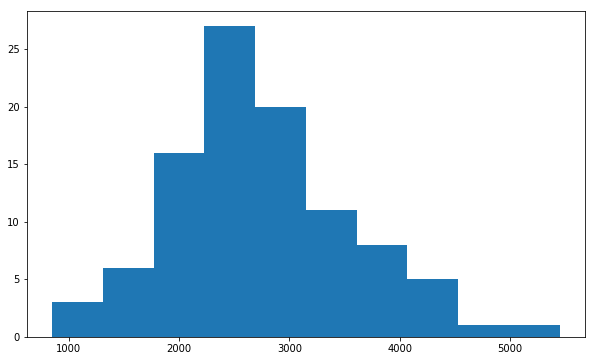

In [12]:
#check distribution of price
from matplotlib import figure 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10,6))
plt.hist(apt_cl['price']);


In [75]:
#export_csv = apt.to_csv(r'\\Users\bnakarmi\Documents\export_dataframe.csv', index = None, header = True)
export_csv = apt_cl.to_csv(r'export_dataframe.csv', index = None, header = True)

In [13]:
def f(row):
    if row['neighborhood'] == 'cupertino':
        val = '37.3230,-122.0322'
        
    elif row['neighborhood'] == 'milpitas':
        val = '37.4323,-121.8996'
        
    elif row['neighborhood'] == 'san jose west':
        val = '337.3020,-121.9970'
    
    elif row['neighborhood'] == 'san jose east':
        val = '37.3262,-121.8202'
    
    elif row['neighborhood'] == 'san jose downtown':
        val = '37.3337,-121.8907'
    
    elif row['neighborhood'] == 'sunnyvale':
        val = '37.3688,-122.0363'
        
    elif row['neighborhood'] == 'santa clara':
        val = '37.3541,-121.9552'
    elif row['neighborhood'] == 'campbell':
        val = '37.2872,-121.9500'
    elif row['neighborhood'] == 'san jose north':
        val = '37.3897,-121.9302'
    elif row['neighborhood'] == 'san jose south':
        val = '37.2802,-121.8362'
    elif row['neighborhood'] == 'mountain view':
        val = '37.3861,-122.0839'
    elif row['neighborhood'] == 'los gatos':
        val = '37.2358,-1121.9624'
        
    else:
        val = 0
        
    return val
    

In [14]:
#adding new lat long column
apt_cl['lat'] = apt_cl.apply(f,axis=1)

#splitting lat long column into two
#apt_cl1 = apt_cl.drop(['lat', 'lat_long'], axis =1)
#apt_cl1

In [15]:
apt_cl[['lat','long']]= apt_cl['lat'].str.split(',',expand=True)
apt_cl.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322


In [16]:
#dropping null values
apt_cl.dropna(how='any')
apt_cl.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322


In [78]:

final_apt = apt_cl.to_csv(r'final_dataframe1.csv', index = None, header = True)

In [17]:
#getting santa clara county crime data
crime = pd.read_csv('/Users/bnakarmi/Documents/coursera/CapStone Project/crime_1.csv')
crime

,city,Population,Violent_crime
0,san jose,1041844,3887
1,santa clara,128179,159
2,cupertino,60948,71
3,campbell,41457,108
4,milpitas,79990,96
5,los gatos,30947,21
6,mountain view,81726,132
7,sunnyvale,154108,158


### 3. Methodology section

This section describes in detail the the steps performed to extract meaningful information from the data sources mentioned above.

#### The analysis and stragegy

The strtegy is based on mapping data obtained to facilitae to choice of at leat one candidate places for rent. The choices will be base on : how safe the place is (amount of voilnet crime, prices range , number of activites available).

The procesing of these DATA and its mapping will allow to answer the key questions to make a decision:
- Which is the safe city for rent?
- Which city has top number of activirities or more thins to do?
- Which city has higher distribution of range prices?


## Mapping of Santa Clara County, California

In [18]:
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /Users/bnakarmi/anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         148 KB

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2019.11.27~ --> conda-forge::ca-certificates-2019.11.28-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                         pkgs/main --> conda-forge
  openssl              pkgs/main::openssl-1.1.1d-h1de35cc_3 --> conda-forge::openssl-1.1.1d-h0b31af3_0



certifi-2019.11.28   | 148 KB    | ##################################### | 100% 
Preparing 

In [21]:
address = 'Downtown San Jose, California'

#geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Jose home are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Jose home are 37.3359104, -121.8910758.


In [22]:
neighborhood_latitude=37.3359104
neighborhood_longitude=-121.8910758

In [23]:
CLIENT_ID = 'VK1AKOSSMHML0TSP30JU55E4TKK0K0LWXLAR12ZZD0M3MNXR' # your Foursquare ID
CLIENT_SECRET = 'BIM0VEVUXVUHVCNDTH41WIJ50MOXMBOXLZBBMESKOWJ0JD0S' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VK1AKOSSMHML0TSP30JU55E4TKK0K0LWXLAR12ZZD0M3MNXR
CLIENT_SECRET:BIM0VEVUXVUHVCNDTH41WIJ50MOXMBOXLZBBMESKOWJ0JD0S


In [24]:
LIMIT = 1500 # limit of number of venues returned by Foursquare API
radius = 40000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


In [25]:
results = requests.get(url).json()


In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']
    
SJnearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng','venue.location.postalCode',
                    'venue.location.city']
SJnearby_venues =SJnearby_venues.loc[:, filtered_columns]

# filter the category for each row
SJnearby_venues['venue.categories'] = SJnearby_venues.apply(get_category_type, axis=1)

# clean columns
SJnearby_venues.columns = [col.split(".")[-1] for col in SJnearby_venues.columns]

In [147]:
print('There are {} unique categories.'.format(len(SJnearby_venues['categories'].unique())))
#print(SJnearby_venues[['categories']])
#frquency of each category
print(SJnearby_venues['categories'].value_counts())

There are 52 unique categories.
Park                         9
Grocery Store                8
Sandwich Place               6
Coffee Shop                  5
Trail                        5
Gym                          5
Wine Shop                    3
Pizza Place                  3
Mexican Restaurant           3
Bakery                       3
American Restaurant          3
Climbing Gym                 2
Burger Joint                 2
Pharmacy                     2
Café                         2
Japanese Restaurant          2
Ice Cream Shop               2
New American Restaurant      1
Farmers Market               1
Shopping Mall                1
Garden                       1
Electronics Store            1
Sporting Goods Shop          1
Frozen Yogurt Shop           1
Marijuana Dispensary         1
Food Court                   1
Peruvian Restaurant          1
Furniture / Home Store       1
Mediterranean Restaurant     1
Boutique                     1
Supermarket                  1
Smoke S

In [28]:
#city 
SJnearby_venues['city']=SJnearby_venues['city'].str.lower()
conm = SJnearby_venues.groupby(['city']).count()
conm

,name,categories,lat,lng,postalCode
city,,,,,
campbell,6,6,6,6,6
cupertino,10,10,10,10,10
los altos,1,1,1,1,1
los gatos,11,11,11,11,10
milpitas,2,2,2,2,2
mountain view,5,5,5,5,5
san jose,45,45,45,45,45
santa clara,7,7,7,7,7
saratoga,5,5,5,5,5


In [29]:
venue_final = conm.to_csv(r'venue_final.csv', index = None, header = True)

In [30]:
#converting san jose downtow, south , north, east,west to only san jose
apt_cl.loc[apt_cl['neighborhood'] .str.contains('san jose'),'neighborhood']='san jose'


In [31]:
#megerging venue table with apt price table
apt_merge = pd.merge(apt_cl,conm[['categories']], left_on='neighborhood', right_on = 'city')
apt_merge.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long,categories
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10
3,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10


In [32]:
crime.city = crime.city.astype(str)
apt_merge.neighborhood = apt_merge.neighborhood.astype(str)

In [33]:
#merge crime data to main dataframe
crime_cl=crime.drop_duplicates()
apt_merge1 = pd.merge(apt_merge,crime, left_on='neighborhood', right_on ='city')
#apt_merge1=pd.merge(apt_merge,crime,on=['city'])
apt_merge1.head()


,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long,categories,city,Population,Violent_crime
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10,cupertino,60948,71
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10,cupertino,60948,71
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10,cupertino,60948,71
3,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10,cupertino,60948,71
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322,10,cupertino,60948,71


In [34]:
#weather["Temp"] = weather.Temp.astype(float)
apt_merge1["lat"] = apt_merge1.lat.astype(float)
apt_merge1["long"] = apt_merge1.long.astype(float)
apt_merge1.dtypes

neighborhood        object
post title          object
number bedrooms      int64
sqft               float64
URL                 object
price                int64
lat                float64
long               float64
categories           int64
city                object
Population           int64
Violent_crime        int64
dtype: object

In [35]:
filter_apt = apt_merge1.groupby(['city']).mean()
filter_apt

,number bedrooms,sqft,price,lat,long,categories,Population,Violent_crime
city,,,,,,,,
campbell,2.500000,1184.833333,2700.000000,37.28720,-121.950000,6.0,41457.0,108.0
cupertino,1.818182,901.909091,2956.818182,37.32300,-122.032200,10.0,60948.0,71.0
los gatos,1.000000,400.000000,3390.000000,37.23580,-1121.962400,11.0,30947.0,21.0
milpitas,1.700000,896.500000,3121.000000,37.43230,-121.899600,2.0,79990.0,96.0
mountain view,2.333333,1235.166667,3415.833333,37.38610,-122.083900,5.0,81726.0,132.0
san jose,1.700000,937.425000,2444.975000,119.81702,-121.911382,45.0,1041844.0,3887.0
santa clara,1.923077,983.538462,2265.384615,37.35410,-121.955200,7.0,128179.0,159.0
sunnyvale,2.181818,1089.454545,3218.181818,37.36880,-122.036300,8.0,154108.0,158.0


## Exploratory Data Analysis

In [36]:
apt_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 108
Data columns (total 8 columns):
neighborhood       98 non-null object
post title         98 non-null object
number bedrooms    98 non-null int64
sqft               98 non-null float64
URL                98 non-null object
price              98 non-null int64
lat                98 non-null object
long               98 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 6.9+ KB


In [37]:
#pd.options.display.max_colwidth = 100
#filetering apt price value
apt_merge1[(apt_merge1['price'] < 7000) & (apt_cl['price'] > 2000)]
apt_merge1.head()

/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long,categories,city,Population,Violent_crime
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.323,-122.0322,10,cupertino,60948,71
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.323,-122.0322,10,cupertino,60948,71
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.323,-122.0322,10,cupertino,60948,71
3,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.323,-122.0322,10,cupertino,60948,71
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.323,-122.0322,10,cupertino,60948,71


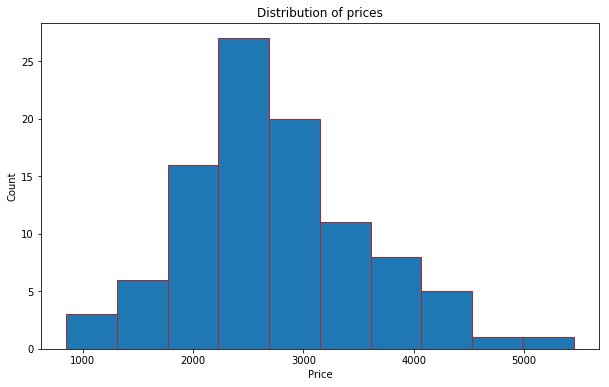

In [38]:
#look for price distribution
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.hist(apt_cl['price'], edgecolor = 'brown');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of prices");

In [39]:
#grouping city and finding mean for no. of bed room, price, sqft
apt_merge1['Violent_crime']=pd.to_numeric(apt_merge1['Violent_crime'])
apt_merge1.groupby('neighborhood').mean()


,number bedrooms,sqft,price,lat,long,categories,Population,Violent_crime
neighborhood,,,,,,,,
campbell,2.500000,1184.833333,2700.000000,37.28720,-121.950000,6.0,41457.0,108.0
cupertino,1.818182,901.909091,2956.818182,37.32300,-122.032200,10.0,60948.0,71.0
los gatos,1.000000,400.000000,3390.000000,37.23580,-1121.962400,11.0,30947.0,21.0
milpitas,1.700000,896.500000,3121.000000,37.43230,-121.899600,2.0,79990.0,96.0
mountain view,2.333333,1235.166667,3415.833333,37.38610,-122.083900,5.0,81726.0,132.0
san jose,1.700000,937.425000,2444.975000,119.81702,-121.911382,45.0,1041844.0,3887.0
santa clara,1.923077,983.538462,2265.384615,37.35410,-121.955200,7.0,128179.0,159.0
sunnyvale,2.181818,1089.454545,3218.181818,37.36880,-122.036300,8.0,154108.0,158.0


In [40]:
apt_sort = pd.DataFrame(apt_merge1.groupby('neighborhood').mean()['price'].sort_values())
apt_sort

,price
neighborhood,
santa clara,2265.384615
san jose,2444.975000
campbell,2700.000000
cupertino,2956.818182
milpitas,3121.000000
sunnyvale,3218.181818
los gatos,3390.000000
mountain view,3415.833333


In [41]:
#### Normalization of data
from sklearn.preprocessing import scale

apt_dp = apt_merge1[['number bedrooms','sqft','price','categories','Violent_crime']]
                
apt_scale = scale(apt_dp)
apt_scale
#convert into dataframe
apt_df = pd.DataFrame(apt_scale)
apt_df.columns = ['number bedrooms','sqft','price','categories','Violent_crime']
apt_df.head()


/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,number bedrooms,sqft,price,categories,Violent_crime
0,0.133432,-0.389577,0.320507,-0.649263,-0.857263
1,0.133432,-0.389577,0.320507,-0.649263,-0.857263
2,0.133432,-0.389577,0.320507,-0.649263,-0.857263
3,0.133432,-0.389577,0.320507,-0.649263,-0.857263
4,0.133432,-0.389577,0.320507,-0.649263,-0.857263


##### Price vs square foot 

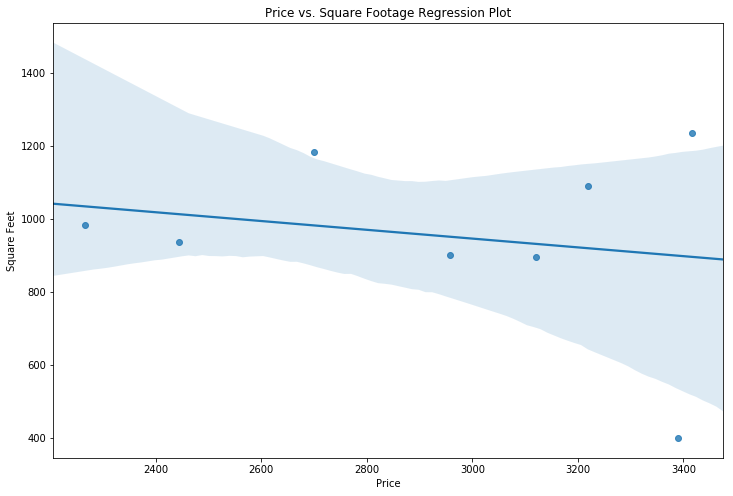

In [42]:
plt.figure(figsize=(12,8))
sns.regplot(x='price', y = 'sqft', data = filter_apt);
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price");
plt.ylabel("Square Feet");

Figure shows square footage is linearly related to price. Lower the square feet lower the price. 

In [43]:
apt_df.corr()

,number bedrooms,sqft,price,categories,Violent_crime
number bedrooms,1.000000,0.875274,0.045696,-0.159760,-0.158889
sqft,0.875274,1.000000,0.036451,-0.080280,-0.074959
price,0.045696,0.036451,1.000000,-0.273189,-0.271006
categories,-0.159760,-0.080280,-0.273189,1.000000,0.994067
Violent_crime,-0.158889,-0.074959,-0.271006,0.994067,1.000000


In [44]:
apt_merge1.describe()

,number bedrooms,sqft,price,lat,long,categories,Population,Violent_crime
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,9.800000e+01,98.000000
mean,1.877551,980.336735,2719.071429,71.015230,-132.161104,22.306122,4.824046e+05,1658.030612
std,0.922405,465.283528,849.658552,95.172947,101.015827,19.051427,4.679698e+05,1860.795132
min,1.000000,350.000000,850.000000,37.235800,-1121.962400,2.000000,3.094700e+04,21.000000
25%,1.000000,702.750000,2223.750000,37.325675,-122.032200,7.000000,7.999000e+04,108.000000
50%,2.000000,862.500000,2650.000000,37.354100,-121.955200,10.000000,1.541080e+05,159.000000
75%,2.000000,1114.750000,3271.250000,37.386100,-121.890700,45.000000,1.041844e+06,3887.000000
max,7.000000,3667.000000,5450.000000,337.302000,-121.836200,45.000000,1.041844e+06,3887.000000


#### Prices by neighboorhood box plot


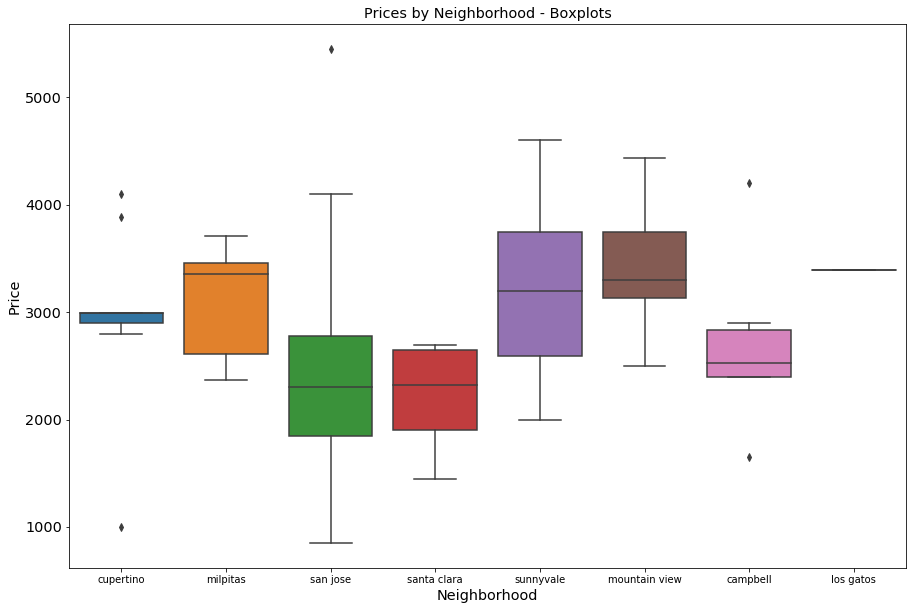

In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))

lbl = {'legend.fontsize': 'x-large',
      'figure.figsize': (15,5),
      'axes.labelsize':'x-large',
      'axes.titlesize':'x-large',
      'ytick.labelsize':'x-large'}
plt.rcParams.update(lbl)

sns.boxplot(x='neighborhood', y='price', data = apt_merge1)
plt.xlabel("Neighborhood");
plt.ylabel("Price")
plt.title("Prices by Neighborhood - Boxplots");

San jose seems to have affordable price range. San Jose city has wider variety of price range distribution. 

In [111]:
url = 'https://opendata.arcgis.com/datasets/cb9923f1ff0941d2b613ba75e40a4440_0.geojson'
# Create URL to JSON file (alternatively this can be a filepath)

# Load the first sheet of the JSON file into a data frame
df = pd.read_json(url)
# View the first ten rows
#print(df.head())
filter_apt

,number bedrooms,sqft,price,lat,long,categories,Population,Violent_crime
city,,,,,,,,
campbell,2.500000,1184.833333,2700.000000,37.28720,-121.950000,6.0,41457.0,108.0
cupertino,1.818182,901.909091,2956.818182,37.32300,-122.032200,10.0,60948.0,71.0
los gatos,1.000000,400.000000,3390.000000,37.23580,-1121.962400,11.0,30947.0,21.0
milpitas,1.700000,896.500000,3121.000000,37.43230,-121.899600,2.0,79990.0,96.0
mountain view,2.333333,1235.166667,3415.833333,37.38610,-122.083900,5.0,81726.0,132.0
san jose,1.700000,937.425000,2444.975000,119.81702,-121.911382,45.0,1041844.0,3887.0
santa clara,1.923077,983.538462,2265.384615,37.35410,-121.955200,7.0,128179.0,159.0
sunnyvale,2.181818,1089.454545,3218.181818,37.36880,-122.036300,8.0,154108.0,158.0


In [139]:
#from shapely.geometry import Point, Polygon
import geopandas as gpd
#states = gpd.read_file('/Users/bnakarmi/Downloads/CityBoundaries.json')
states = gpd.read_file('/Users/bnakarmi/Downloads/500Cities_City_11082016/CityBoundaries.shp')
#print(states)
cal=states[states['ST'] == 'CA']
array = ['Cupertino','Los Gatos','Milpitas','Mountain View','San Jose','Santa Clara','Sunnyvale','Campbell']
#cal1=cal.loc[(cal['NAME'] == 'San Jose') & (cal['NAME'] == 'Union City')]
cal1 = cal.loc[cal['NAME'].isin(array)]
#cal1['NAME'].str.lower()
cal1['NAME']=cal1['NAME'].str.lower()
cal1
#states.plot(column='POP2010')
#states = states.to_json()
#print(states)
cal1 = cal1.rename(columns={'NAME': 'city'})
cal1

/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,city,CLASS,ST,STFIPS,PLACEFIPS,POP2010,STPLFIPS,geometry
442,mountain view,city,CA,06,49670,74066,0649670,"POLYGON ((-13586159.481 4495420.531, -13586209..."
447,sunnyvale,city,CA,06,77000,140081,0677000,"POLYGON ((-13579514.150 4496699.886, -13579514..."
448,santa clara,city,CA,06,69084,116468,0669084,"POLYGON ((-13581352.253 4484215.853, -13581381..."
457,milpitas,city,CA,06,47766,66790,0647766,"POLYGON ((-13569564.300 4504177.324, -13569534..."
460,san jose,city,CA,06,68000,945942,0668000,"MULTIPOLYGON (((-13561354.371 4468029.506, -13..."


In [164]:
bnd_cal = cal1.merge(filter_apt,on='city')

bnd_cal['price'] = bnd_cal['price'].astype('int')
bnd_cal['city'] = bnd_cal['city'].astype('str')
bnd_cal.dtypes

city                 object
CLASS                object
ST                   object
STFIPS               object
PLACEFIPS            object
POP2010               int64
STPLFIPS             object
geometry           geometry
number bedrooms     float64
sqft                float64
price                 int64
lat                 float64
long                float64
categories          float64
Population          float64
Violent_crime       float64
dtype: object

In [141]:
#adding base map
mymap = folium.Map(location=[37.3359104, -121.8910758], zoom_start=11,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
mymap

In [49]:
#One = gpd.read_file('/Users/bnakarmi/Downloads/500Cities_City_11082016/CityBoundaries.shp')  
#mapa = folium.Map([2, -75], zoom_start=10, tiles='Stamen Toner',API_key='wrobstory.map-12345678')
#folium.GeoJson(One).add_to(mapa)
#mapa

import json
import ogr

driver = ogr.GetDriverByName('ESRI Shapefile')
shp_path = r'/Users/bnakarmi/Downloads/500Cities_City_11082016/CityBoundaries.shp'
data_source = driver.Open(shp_path, 0)

fc = {
    'type': 'FeatureCollection',
    'features': []
    }

lyr = data_source.GetLayer(0)
for feature in lyr:    
    fc['features'].append(feature.ExportToJson(as_object=True))

with open('counties.json', 'w') as f:
    json.dump(fc, f)

In [168]:
import pandas as pd
import folium
import os

m = folium.Map(location=[37.3359104, -121.8910758], zoom_start=3)
# Add the color for the chloropleth:
m.choropleth(
 geo_data=bnd_cal,
 name='choropleth',
 data=bnd_cal,
 columns=['city', 'price'],
 key_on='city',
 fill_color='YlGnBu',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Unemployment Rate (%)'
)
folium.LayerControl().add_to(m)
 
#Save to html
#m.save('map.html')

m
#from IPython.display import HTML
#HTML('<iframe src=plot_data.html width=700 height=450></iframe>')

In [61]:
import folium
def generateBaseMap(default_location=[37.3359104, -121.8910758], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [62]:
base_map = generateBaseMap()


##### Violent Crime cluster

In [63]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=apt_merge1[['lat', 'long', 'Violent_crime']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=20, max_zoom=20).add_to(base_map)
base_map

##### High Price Cluster

In [72]:
from folium.plugins import HeatMap
#df_copy = df[df.month>4].copy()
#df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=apt_merge1[['lat', 'long', 'price']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=25, max_zoom=20).add_to(base_map)
base_map

##### Top venues cluster

In [68]:
from folium.plugins import HeatMap
#df_copy = df[df.month>4].copy()
#df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=apt_merge1[['lat', 'long', 'categories']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=35, max_zoom=20).add_to(base_map)
base_map

### Results  and Discussion

Based on the data analysis we can summerize that:Santa Clara County craiglist data has following findings: 
- Square footage is linearly related to price. Lower the square feet lower the price.
- San jose seems to have affordable price range. San Jose city has wider variety of price range distribution.
- Price Range 2500 to 4000 are listed more than any other price range.
- San Jose city has highest amount of violent crime. Campbell, Mountain View and Cupertino has lowest crime occurance. 

## Conclusion:

After examming the data and map produced above, I have choosen one location that meet the requirement:
San jose downtown has lot of top venues but it also has high number of violent crime. I decided not to consider this location due to amount of crime. 
Milpitas has less number of crime and it has second high number of top venue. 
I choosed Milpitas as top choice for rent. 
